# Factors

## A: Standard Scaling (applied or not applied)

## B: PCA to 10 dimensions (applied or not applied)

## C: Data Augmentation (random vertical flip, applied or not applied)

## D: Model type (DecisionTreeClassifier or LogisticRegression)

# Response variable

## Accuracy

# The task

Training a classifier on a MNIST dataset

## MNIST

something something a classic benchmark for machine learning classification and more, proposed by Yann Le Cun etc. [Nice picture etc.]

# Setting

## Train test split approach

60k vs 10k (following paper by Le Cun), a single split to maintain comparability between experiments (i.e. train set and test set are always the same)

## Classifiers

Default configuration, this type of experiment makes playing aroung with hyperparameters a bit problematic

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

try:
    X = pd.read_csv('data/X.csv', index_col=0)
    y = pd.read_csv('data/y.csv', index_col=0)
except:
    X, y = fetch_openml('mnist_784', data_home='data', version=1, return_X_y=True)

In [2]:
import matplotlib.pyplot as plt

In [4]:
y.values[0]

array([5])

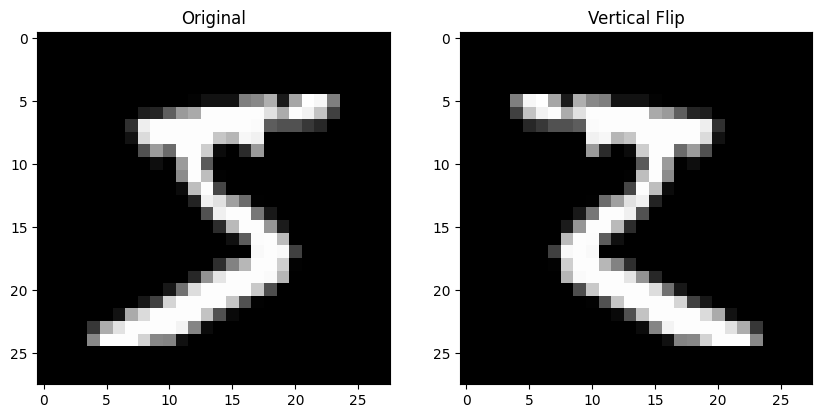

In [3]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X.values.reshape(-1, 28, 28)[0], cmap="gray")
axs[1].imshow(X.values.reshape(-1, 28, 28)[0][:, ::-1], cmap="gray")
axs[0].set_title("Original")
axs[1].set_title("Vertical Flip")
plt.show()

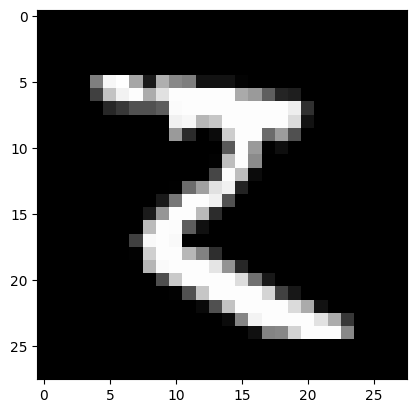

In [4]:
plt.imshow(X.values.reshape(-1, 28, 28)[0][:, ::-1], cmap="gray");

In [5]:
from sklearn.model_selection import train_test_split
def train_test_data(X, y, test_size=10_000, seed=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train.values, X_test.values, y_train.values, y_test.values

In [6]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(X_train, X_test, apply):
    if apply:
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
    return X_train, X_test

In [7]:
from sklearn.decomposition import PCA
def pca(X_train, X_test, apply, n_components=50):
    if apply:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

In [19]:
import numpy as np


def augment_data(
    X_train: np.ndarray,
    y_train: np.ndarray,
    apply: bool,
    seed=123,
):
    if apply:
        np.random.seed(seed)
        mask = np.random.permutation(X_train.shape[0])[: X_train.shape[0] // 2]
        X_train_augmented = X_train[mask].reshape(-1, 28, 28)[:, :, ::-1].reshape(-1, 28 * 28)
        y_train_augmented = y_train[mask]
        X_train = np.concatenate([X_train, X_train_augmented], axis=0)
        y_train = np.concatenate([y_train, y_train_augmented], axis=0)

    return X_train, y_train


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
def train_model(X_train, y_train, model):
    if model:
        clf = LogisticRegression(random_state=123)
    else:
        clf = DecisionTreeClassifier(random_state=123)
    clf.fit(X_train, y_train)
    return clf
    

In [23]:
def evaluate(X_test, y_test, clf):
    return clf.score(X_test, y_test)

In [24]:
def run_single(X_train, X_test, y_train, y_test, A, B, C, D):
    X_train, X_test = standard_scaling(X_train, X_test, apply=A)
    X_train, X_test = pca(X_train, X_test, apply=B)
    X_train, y_train, X_test, y_test = get_random_shuffle(X_train, y_train, X_test, y_test, apply=C)
    clf = train_model(X_train, y_train, model=D)
    return evaluate(X_test, y_test, clf)

In [50]:
import itertools
import pandas as pd
from tqdm import tqdm

import multiprocessing

class SingleRunProcess(multiprocessing.Process):
    def __init__(self, X_train, X_test, y_train, y_test, A, B, C, D, results_q):
        multiprocessing.Process.__init__(self)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.results_q = results_q

    def run(self):
        score = run_single(self.X_train, self.X_test, self.y_train, self.y_test, self.A, self.B, self.C, self.D)
        self.results_q.put([self.A, self.B, self.C, self.D, score])



In [ ]:


def run():
    X_train, X_test, y_train, y_test = train_test_data(X, y)
    results = []
    results_q = multiprocessing.Queue()
    factors = ["A", "B", "C", "D"]
    response = ["Y"]
    for A, B, C, D in tqdm(itertools.product([True, False], repeat=4)):
        p = SingleRunProcess(X_train, X_test, y_train, y_test, A, B, C, D, results_q)
        p.start()
    
    for _ in tqdm(range(2 ** 4)):
        p.join()
        results.append(results_q.get())
    df = pd.DataFrame(results, columns=factors + response)
    df[factors] = df[factors].applymap(lambda x: {True: 1, False: -1}[x])
    for comb_size in range(1, len(factors) + 1):
        for comb in itertools.combinations(factors, comb_size):
            df["".join(comb)] = df[list(comb)].prod(axis=1)
        
    df = df[[c for c in df.columns if c != "Y"] + ["Y"]]
    return df

In [ ]:
def save_results(df):
    df.to_csv("data/results.csv")

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("data/results.csv", index_col=0)

In [195]:
df

,A,B,C,D,AB,AC,AD,BC,BD,CD,ABC,ABD,ACD,BCD,ABCD,Y
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,72.38
1,1,1,1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,77.56
2,1,1,-1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,77.65
3,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,82.16
4,1,-1,1,1,-1,1,1,-1,-1,1,-1,-1,1,-1,-1,85.39
5,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,1,1,86.98
6,1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,1,1,89.49
7,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,87.46
8,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,74.34
9,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,79.97


In [196]:
TARGET = "Y"
FTS = [c for c in df.columns if c != TARGET]
X_, Y_ = df[FTS].values, df[TARGET].values

In [197]:
beta_hat = 1/X_.shape[0] * X_.T @ Y_

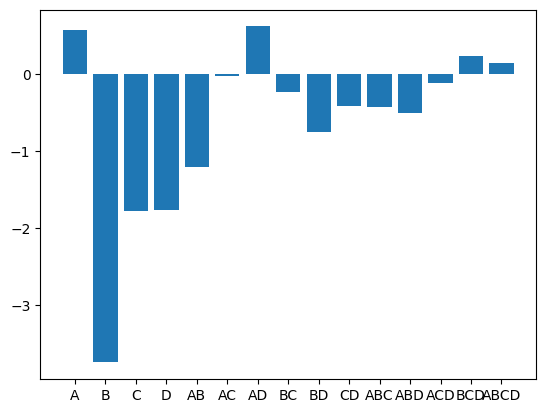

In [198]:
plt.bar(FTS, beta_hat);

In [199]:
effects = 2*beta_hat

In [200]:
m = np.median(np.abs(effects))
s_0 = 1.5 * m
s_0, m

(1.5356249999999942, 1.0237499999999962)

In [201]:
effects[np.where(np.abs(effects) < 2.5 * s_0)]

array([ 1.12625, -3.56625, -3.53625, -2.41625, -0.04625,  1.22375,
       -0.47375, -1.50875, -0.82375, -0.84875, -1.02375, -0.24875,
        0.46375,  0.27375])

In [202]:
m_fin = np.median(np.abs(effects[np.where(np.abs(effects) < 2.5 * s_0)]))
m_fin

0.9362499999999958

In [203]:
pse = 1.5 * m_fin

In [204]:
sigma_hat = pse

In [205]:
T = effects / pse

In [206]:
alpha = 0.95

In [207]:
m

1.0237499999999962

In [208]:
np.abs(effects), m//3

(array([1.12625, 7.47625, 3.56625, 3.53625, 2.41625, 0.04625, 1.22375,
        0.47375, 1.50875, 0.82375, 0.84875, 1.02375, 0.24875, 0.46375,
        0.27375]),
 0.0)

In [209]:
T

array([ 0.80195817, -5.3235425 , -2.53938585, -2.51802403, -1.72051624,
       -0.0329328 ,  0.87138407, -0.33733867, -1.07432132, -0.58655986,
       -0.60436137, -0.72897196, -0.17712506,  0.33021807,  0.19492657])

In [210]:
from scipy.stats import t

In [211]:
t.interval(0.95, 1)

(-12.706204736432095, 12.706204736432095)

In [212]:
sigma_2_hat = 1/5 * np.sum(effects[-5:]**2)

In [216]:
effects / np.sqrt(sigma_2_hat)

array([  1.72949404, -11.48069239,  -5.4764112 ,  -5.43034255,
        -3.71044614,  -0.07102251,   1.87921716,  -0.72750082,
        -2.31686937,  -1.26496845,  -1.30335899,  -1.5720928 ,
        -0.38198592,   0.7121446 ,   0.42037646])

In [214]:
np.abs(T) >= 2.5

array([False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False])

In [215]:
t.interval(0.95, 5)

(-2.5705818366147395, 2.5705818366147395)